In [1]:
#execute this cell once in the beginning to define all necessary functions

import matplotlib.pyplot as plt
import networkx as nx
from scipy.signal import find_peaks

#read graph from txt file
def readGraphFrom(file):
    G = nx.read_edgelist(file, create_using=nx.Graph(), nodetype=str, data=(('og_weight', float),))
    return G

def _partialEdgeBetweenness(G):
    #create graph to store partial edge betweenness
    NG = G.copy()
    #choose each node as root once
    for root in G:
        #create ShortestPathGraph
        SPG = nx.Graph()
        #calculate shotest path from each node to root and add edges to SPG
        for vertex in G:
            for shortest_path in nx.all_shortest_paths(G, source=vertex, target=root, weight='og_weight'):
                SPG.add_path(shortest_path)
        
        #copy distances from original graph to shortest path graph
        for edge in SPG.edges:
            SPG.edges[edge]['og_weight'] = G.edges[edge]['og_weight']
                    
        #calculate distance and weight for each node in SPG
        max_distance = 0
        for node in SPG:
            if node == root:
                SPG.nodes[node]['distance'] = 0
                SPG.nodes[node]['weight'] = 1
            else:
                distance = nx.shortest_path_length(SPG, source=root, target=node, weight='og_weight')
                #compute maximal distance from root (needed in later steps)
                if distance > max_distance:
                    max_distance = distance
                SPG.nodes[node]['distance'] = distance
                SPG.nodes[node]['weight'] = len(list(nx.all_shortest_paths(SPG, source=root, target=node, weight='og_weight')))
                
        #calculate partial betweenness scores for leaf edges
        for leaf in SPG:
            if SPG.nodes[leaf]['distance'] == max_distance:
                for node1, node2 in SPG.edges(leaf):
                    if node1 == leaf:
                        neighbor = node2
                    else:
                        neighbor = node1
                    SPG.edges[node1, node2][root] = SPG.nodes[neighbor]['weight']/SPG.nodes[leaf]['weight']
                    NG.edges[node1, node2][root] = SPG.nodes[neighbor]['weight']/SPG.nodes[leaf]['weight']
        
        #calculate partial betweenness scores for all other edges by decreasing maximal distance in each iteration
        while max_distance > 1:
            max_distance = max_distance-1
            for node in SPG:
                #only look at nodes at the current distance level
                if SPG.nodes[node]['distance'] == max_distance:
                    for node1, node2 in SPG.edges(node):
                        if node1 == node:
                            neighborUP = node2
                        else:
                            neighborUP = node1
                        if SPG.nodes[neighborUP]['distance'] <= max_distance - 1:
                            sum_of_scores = 0
                            for node11, node22 in SPG.edges(node):
                                if node11 == node:
                                    neighborDOWN = node22
                                else:
                                    neighborDOWN = node11
                                if SPG.nodes[neighborDOWN]['distance'] >= max_distance + 1:
                                    sum_of_scores = sum_of_scores + SPG.edges[neighborDOWN, node][root]
                            #set score for edge from current distance level to one level above (root is at top)
                            SPG.edges[node, neighborUP][root] = (1 + sum_of_scores)*SPG.nodes[neighborUP]['weight']/SPG.nodes[node]['weight']
                            NG.edges[node, neighborUP][root] = (1 + sum_of_scores)*SPG.nodes[neighborUP]['weight']/SPG.nodes[node]['weight']
                            
    return NG

#calculate edge betweenness for graph
def edgeBetweenness(G, node1, node2):
    NG = G.copy()
    
    for component in nx.connected_component_subgraphs(NG):
        #recalculate betweenness scores for graph components that contain at least one of the nodes from the last
        #removed edge
        if component.has_node(node1) or component.has_node(node2) or (node1 == 0 and node2 == 0):
            SPG = _partialEdgeBetweenness(component)
            
            for edge in SPG.edges:
                SPG.edges[edge]['weight'] = 0
                for root in SPG:
                    if root in SPG.edges[edge]:
                        SPG.edges[edge]['weight'] = SPG.edges[edge]['weight'] + SPG.edges[edge][root]
                        
            #copy final scores to new graph
            for edge in SPG.edges:
                NG.edges[edge]['weight'] = SPG.edges[edge]['weight']

    return NG

#determine edge with maximal betweenness score
def maxScoreEdge(G):
    maxScore = 0.0
    for edge in G.edges:
        if maxScore < G.edges[edge]['weight']:
            maxScore = G.edges[edge]['weight']
            edgeRemove = edge
    return edgeRemove

#remove edge from graph
def removeEdge(edge, G):
    G.remove_edge(edge[0], edge[1])
    return G

In [2]:
#execute this cell if a new graph should be loaded

G = readGraphFrom("graph.txt")
#G = nx.karate_club_graph()

for edge in G.edges:
    #set all the betweenness score to 0 to initalize
    G.edges[edge]['weight'] = 0
    #if there are no weights in the Graph, uncomment this line to set all the weights to 1
    #G.edges[edge]['og_weight'] = 1

In [3]:
#execute this cell to apply girvan-newman to the graph G

Graphs = [G]
Mod = [nx.algorithms.community.modularity(G, list(nx.connected_components(G)), weight='og_weight')]

num_iter = len(G.edges)
e = (0, 0)
NG = G.copy()

print("Remaining Edges: ")

#iterate as many times as there are edges in the graph
while num_iter > 0:
    #just that we can see progress of algorithm
    print(num_iter, end = " ")
    num_iter = num_iter - 1
    #calculate edge betweenness and store values in new graph 
    NG = edgeBetweenness(NG, e[0], e[1])
    e = maxScoreEdge(NG)
    removeEdge(e, NG)
    
    #add graph and modularity to list
    Graphs.append(NG)
    Mod.append(nx.algorithms.community.modularity(G, list(nx.connected_components(NG)), weight='og_weight'))

Remaining Edges: 
1526 1525 1524 1523 1522 1521 1520 1519 1518 1517 1516 1515 1514 1513 1512 1511 1510 1509 1508 1507 1506 1505 1504 1503 1502 1501 1500 1499 1498 1497 1496 1495 1494 1493 1492 1491 1490 1489 1488 1487 1486 1485 1484 1483 1482 1481 1480 1479 1478 1477 1476 1475 1474 1473 1472 1471 1470 1469 1468 1467 1466 1465 1464 1463 1462 1461 1460 1459 1458 1457 1456 1455 1454 1453 1452 1451 1450 1449 1448 1447 1446 1445 1444 1443 1442 1441 1440 1439 1438 1437 1436 1435 1434 1433 1432 1431 1430 1429 1428 1427 1426 1425 1424 1423 1422 1421 1420 1419 1418 1417 1416 1415 1414 1413 1412 1411 1410 1409 1408 1407 1406 1405 1404 1403 1402 1401 1400 1399 1398 1397 1396 1395 1394 1393 1392 1391 1390 1389 1388 1387 1386 1385 1384 1383 1382 1381 1380 1379 1378 1377 1376 1375 1374 1373 1372 1371 1370 1369 1368 1367 1366 1365 1364 1363 1362 1361 1360 1359 1358 1357 1356 1355 1354 1353 1352 1351 1350 1349 1348 1347 1346 1345 1344 1343 1342 1341 1340 1339 1338 1337 1336 1335 1334 1333 1332 1331 13

In [4]:
#uncomment and execute this cell, if you want to see all paritions and the corresponding modularity
#the algorithm returns

#for g in Graphs:
#    print("Components:")
#    print(list(nx.connected_components(g)))
#    print(g.edges)
               
#for mod in Mod:
#    print("Modularity:")
#    print(mod)

Communities with local maximal modularity:
Number of removed edges:  7
Modularity:
0.9825901895157385
Communities:
[{'04564634a13cfe18', 'fd8aab26d9d60fa9', '22878bb7c8e36cee', '3e14755be8fb6d2b'}, {'bfcd2a1c8d33081f', '48a86db8e2370425', '6dd46b6d06209f25', '8dfea3396c3ad262', '2afc5fab21b980a4', '2102d1f1238117f5', '7f32e99a32fc1c1c', '985d460dd0824d1f', '1cc3c636b852dd3a', 'b12a133e828edaa6'}, {'4f01900a95f557ed', 'b5757e2724fd1b9b'}, {'5bddb757fdbae201', '13e8f261e6dc1b0f', '153e04c866671b9c', '6a25bd8591e4d2ba', 'b5e76b823b98c4e7', 'cf3c55e8a2ecac1c', '1e04f1e989f7eb3a', '917480ccaa82dab8', '64d1041c17832ba0', 'a4337353dbad4461', '4a6bf0543a70a945', '8c4f835b754d28aa', '22ac7dc718931bbb', '34b92b11e4a4de4b', '135e02db4b6406ea', '6fbd36dd72b9c8ee', 'cb03f2b65b98ddc4', 'aa9a29c837ba4f8c', '0530df5da0f6cccb', 'a956ae2d056800dc', '8125703c773c9949', 'f40fc97891f1c56e', 'e6542f81434ab7fd', '4214e5a42bd42f65', '7c0b241000d4c939', '6cad32ff2ab5dc61', '01273a83c94d5def', 'a5664ea38c840240

/home/yvonne/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


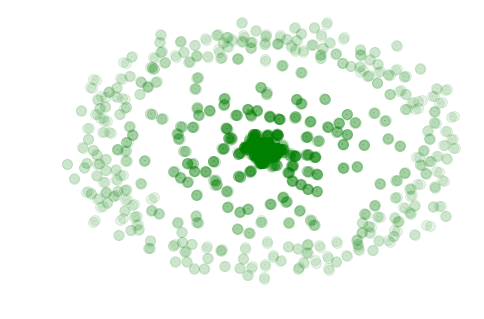

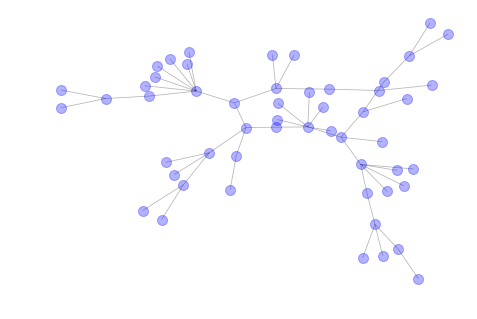

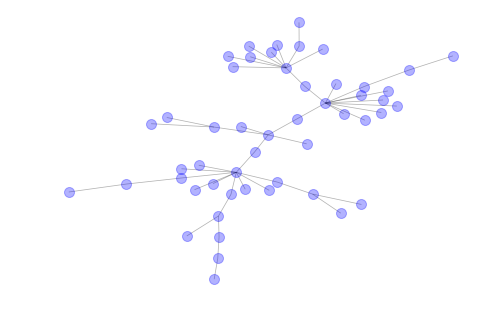

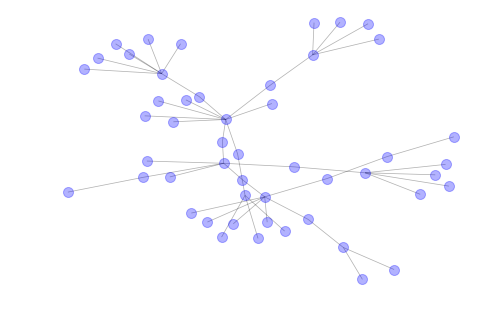

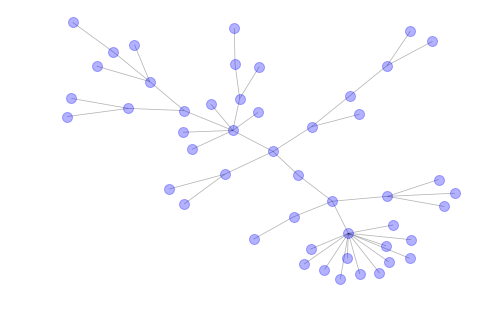

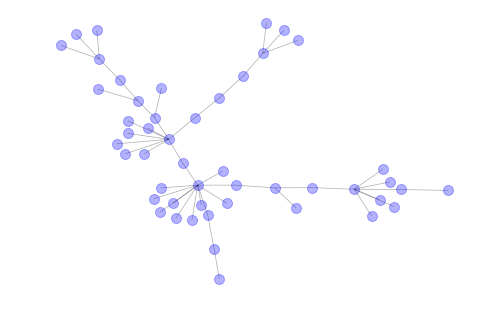

In [5]:
#execute this cell, to print and draw the graph of those partions where the modularity is locally maximal

print("Communities with local maximal modularity:")

#find local maxima in modularity array
index_max_mod_np, _ = find_peaks(Mod)
index_max_mod = index_max_mod_np.tolist()

if not index_max_mod:
#    index_max_mod.append(0)
    index_max_mod.append(1)

options = {'node_color': 'green', 'node_size': 100, 'width': 0.75, 'alpha': 0.1}
    
#print modularity and communities for local maxima
for i in index_max_mod:
    print("Number of removed edges: ", i)
    print("Modularity:")
    print(Mod[i])
    print("Communities:")
    print(list(nx.connected_components(Graphs[i])))
    
    #write graph to output file
    outputfile = "output10secstep" + str(i) + ".txt"
    nx.write_edgelist(Graphs[i], outputfile, data=['og_weight'])

    #draw graph
    nx.draw_spring(Graphs[i], **options)
    plt.savefig("graph.pdf")
    plt.show()
    
    options = {'node_color': 'blue', 'node_size': 100, 'width': 0.75, 'alpha': 0.3}
    
    giant = sorted(nx.connected_component_subgraphs(Graphs[i]), key=len, reverse=True)
    giant_components = 5
    #G = giant[0]
    G = Graphs[i]
    
    if len(giant) < giant_components:
        giant_components = len(giant)
    
    #draw largest graph components
    i = 0
    while i < giant_components:
        nx.draw_spring(giant[i], **options)
        filename = "giant" + str(i) + ".pdf"
        plt.savefig(filename)
        plt.show()
        i = i+1
    

In [6]:
#execute this cell to show the sizes of all components for the partitions that are locally maximal

#print size of components
for i in index_max_mod:
    result = list(sorted(nx.connected_components(Graphs[i]), key=len, reverse=True))
    print("Size of components: ")
    for comp in result:
        print(len(comp), end = " ")

Size of components: 
53 51 50 49 49 43 42 41 40 37 33 29 25 24 22 21 20 20 17 16 15 14 14 13 12 12 12 11 11 11 10 10 10 10 10 10 9 8 8 8 8 8 8 7 7 7 7 7 7 7 7 7 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 

In [7]:
#execute this cell to show the sizes of all components of the original graph G

#print size of components
result = list(sorted(nx.connected_components(G), key=len, reverse=True))
print("Size of components: ")
for comp in result:
    print(len(comp), end = " ")

Size of components: 
53 51 50 49 49 43 42 41 40 37 33 29 25 24 22 21 20 20 17 16 15 14 14 13 12 12 12 11 11 11 10 10 10 10 10 10 9 8 8 8 8 8 8 7 7 7 7 7 7 7 7 7 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 